In [1]:
import torch
import joblib
import numpy as np
from torch import nn
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
from data.data_loader import DroneGraphDataset
from models.pretrained_model_loader import (
    load_pretrained_traj_model,
    extract_context_embeddings,
    extract_decoder_embeddings,
)
from models.tgn import DroneRelationModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DroneGraphDataset(
    trajectory_csv="data/drone_states.csv",
    relationship_csv="data/drone_relations.csv",
    lookback=50,
    device=device,
)

sample = dataset[0]
print(sample["context_window"].shape)  # [50, num_drones, 4]
print(sample["current_features"].shape)  # [num_drones, 4]
print(sample["relationships"].shape)  # [num_pairs, 2]
# print(sample['labels'].shape)            # [num_pairs]


[Skipping] Flight 0, timestep 30.4 has 5 drones
[Skipping] Flight 1, timestep 33.267 has 1 drones
[Skipping] Flight 3, timestep 30.667 has 3 drones
[Skipping] Flight 4, timestep 33.9 has 1 drones
[Skipping] Flight 5, timestep 32.533 has 1 drones
[Skipping] Flight 6, timestep 31.367 has 2 drones
[Skipping] Flight 7, timestep 23.9 has 5 drones
[Skipping] Flight 8, timestep 29.4 has 5 drones
[Skipping] Flight 9, timestep 28.1 has 1 drones
[Skipping] Flight 10, timestep 34.5 has 4 drones
[Skipping] Flight 11, timestep 34.633 has 4 drones
[Skipping] Flight 12, timestep 33.733 has 3 drones
[Skipping] Flight 13, timestep 30.933 has 3 drones
[Skipping] Flight 14, timestep 33.8 has 4 drones
[Skipping] Flight 15, timestep 33.567 has 5 drones
[Skipping] Flight 16, timestep 31.7 has 5 drones
[Skipping] Flight 17, timestep 33.467 has 1 drones
[Skipping] Flight 18, timestep 35.733 has 1 drones
[Skipping] Flight 19, timestep 32.167 has 3 drones
[Skipping] Flight 21, timestep 31.5 has 5 drones
[Skippi

In [3]:
# Example usage
experiment_dir = Path("experiments/20251106_181528")

# Load model + config
model, config = load_pretrained_traj_model(experiment_dir, device)

# Load scalers
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Dummy trajectory data (replace with your actual drone trajectory segment)
dummy_data = np.random.rand(100, 6 * 3).astype(
    np.float32
)  # 100 timesteps, 6 drones, xyz

# Extract embeddings
context_emb = extract_context_embeddings(
    model,
    traj_data=dummy_data,
    scaler_X=scaler_X,
    lookback=config["LOOK_BACK"],
    features_per_agent=6,
    device=device,
)

print("Context embeddings shape:", context_emb.shape)

Context embeddings shape: torch.Size([3, 128])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
from torch.utils.data import Subset

flight_ids = dataset.flights
num_train = int(0.8 * len(flight_ids))
train_flights = flight_ids[:num_train]
test_flights = flight_ids[num_train:]

train_indices = [
    i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in train_flights
]
test_indices = [
    i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in test_flights
]

train_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)

In [5]:
def balance_pairs(relationships, labels, max_neg_per_pos=1):
    """
    Undersample negative pairs so the ratio between negatives and positives
    is roughly `max_neg_per_pos` : 1.
    """
    pos_mask = labels == 1
    neg_mask = labels == 0

    pos_indices = torch.nonzero(pos_mask).squeeze(1)
    neg_indices = torch.nonzero(neg_mask).squeeze(1)

    num_pos = len(pos_indices)
    num_neg = len(neg_indices)
    if num_pos == 0 or num_neg == 0:
        return relationships, labels  # skip balancing if only one class

    # Sample negatives
    num_keep_neg = min(num_neg, num_pos * max_neg_per_pos)
    sampled_neg_indices = neg_indices[torch.randperm(num_neg)[:num_keep_neg]]

    # Combine and shuffle
    keep_indices = torch.cat([pos_indices, sampled_neg_indices])
    keep_indices = keep_indices[torch.randperm(len(keep_indices))]

    return relationships[keep_indices], labels[keep_indices]

In [6]:
def hybrid_topk(probs, k=1, threshold=0.5):
    """
    probs: [num_friendly, num_unauth] (softmax probabilities per friendly)
    k: max number of relations per friendly to keep
    threshold: minimum probability to keep an edge
    
    Returns:
        binary mask: same shape as probs, 1 where selected, else 0
    """
    num_friendly, num_unauth = probs.shape
    selection = torch.zeros_like(probs)

    topk_vals, topk_idx = torch.topk(probs, k, dim=1)
    for i in range(num_friendly):
        keep_mask = topk_vals[i] > threshold
        selection[i, topk_idx[i, keep_mask]] = 1.0

    return selection

In [7]:
def train_epoch(
    model, loader, optimizer, criterion, scaler_X, pretrained_model, config
):
    model.train()
    pretrained_model.train()
    total_loss = 0
    for batch in tqdm(
        loader, desc="Training", leave=True, ncols=100, dynamic_ncols=True
    ):
        context_window = (
            batch["context_window"].squeeze(0).to(device)
        )  # [50, num_drones, 4]
        current_features = batch["current_features"].squeeze(0).to("cpu")
        relationships = batch["relationships"].squeeze(0).to("cpu")
        
        ## Sigmoid labels
        # labels = batch["labels"].squeeze(0).float().to("cpu")

        # --- New: target indices per friendly drone ---
        target_indices = batch["target_indices"].squeeze(0).to(device)  # [num_friendly]

        num_friendly = batch["num_friendly"]
        num_unauth = batch["num_unauth"]

        # relationships, labels = balance_pairs(relationships, labels, max_neg_per_pos=1)
        relationships = batch["relationships"].squeeze(0).to(device)

        # Extract context embeddings from pretrained model
        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :6].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=6,
            device="cpu",
        )

        # preds = model(current_features, context_emb, relationships)
        # loss = criterion(preds, labels)

        probs, logits = model(current_features, context_emb, relationships, num_friendly, num_unauth)
        loss = criterion(logits, target_indices)  # logits: [num_friendly, num_unauth]

        # custom weighting
        # weights = torch.where(labels == 1, 2.0, 1.0)  # higher weight for 1s
        # loss = (weights * loss).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [8]:
# from models.vgae import GCNLayer, VGAE, reconstruction_loss, kl_divergence, build_adj_from_pairs
# from tqdm import tqdm

# # --- TRAINING LOOP ---
# def train_epoch_vgae(vgae_model, loader, optimizer, scaler_X, pretrained_model, config, device="cpu"):
#     vgae_model.train()
#     pretrained_model.train()
#     total_loss = 0.0

#     for batch in tqdm(loader, desc="Training", leave=True, ncols=100, dynamic_ncols=True):
#         context_window = batch["context_window"].squeeze(0).to(device)  # [T, N, 4]
#         relationships = batch["relationships"].squeeze(0).to(device)
#         labels = batch["labels"].squeeze(0).float().to(device)

#         relationships, labels = balance_pairs(relationships, labels, max_neg_per_pos=1)

#         # === 1. Extract context embeddings ===
#         context_emb = extract_decoder_embeddings(
#             pretrained_model,
#             traj_data=context_window[:, :, :3].reshape(context_window.shape[0], -1),
#             scaler_X=scaler_X,
#             lookback=config["LOOK_BACK"],
#             features_per_agent=3,
#             device=device,
#         )  # [num_drones, hidden_dim]

#         num_nodes = context_emb.size(0)
#         adj = build_adj_from_pairs(num_nodes, relationships, labels, directed=True, self_loops=True, device=device)

#         # === 2. Forward VGAE ===
#         scores, mu, logvar = vgae_model(context_emb, adj)

#         # === 3. Compute losses ===
#         recon_loss = reconstruction_loss(scores, adj)
#         kld = kl_divergence(mu, logvar)
#         loss = recon_loss + kld  # (you can scale kld if needed, e.g., loss = recon_loss + 0.1 * kld)

#         # === 4. Backprop ===
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(loader)

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)


@torch.no_grad()
def evaluate(model, loader, scaler_X, pretrained_model, config, show_confusion=True):
    model.eval()
    pretrained_model.eval()
    preds_all, labels_all = [], []
    # inspected = 0
    # inspect_n = 9

    for batch in tqdm(
        loader, desc="Evaluating", leave=True, ncols=100, dynamic_ncols=True
    ):
        context_window = batch["context_window"].squeeze(0).cpu().numpy()
        current_features = batch["current_features"].squeeze(0).to("cpu")
        # labels = batch["labels"].squeeze(0).float().to("cpu")
        relationships = batch["relationships"].squeeze(0).to(device)

        target_indices = batch["target_indices"].squeeze(0).to("cpu")
        num_friendly = batch["num_friendly"]
        num_unauth = batch["num_unauth"]

        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :6].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=6,
            device=device,
        )

        # preds = model(current_features, context_emb, relationships)
        # preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities

        probs, logits = model(current_features, context_emb, relationships, num_friendly, num_unauth)
        
        # pred_mask = hybrid_topk(probs, k=1, threshold=0.4)
        
        # Predicted unauthorized drone per friendly
        preds = torch.argmax(probs, dim=1)

        # Flatten for metrics: make sure labels shape matches preds shape
        # This is for top-k method
        # labels_matrix = target_indices.view(num_friendly, num_unauth)
        # y_true = labels_matrix.cpu().numpy().flatten()
        # y_pred = preds.cpu().numpy().flatten()

        # preds_all.append(torch.tensor(y_pred))
        # labels_all.append(torch.tensor(y_true))

        preds_all.append(preds)
        labels_all.append(target_indices)

        # Inspect first few data points
        # if inspected < inspect_n:
        #     print(
        #         f"Predicted logits: {preds[:inspect_n].detach().cpu().numpy().flatten()}"
        #     )
        #     print(
        #         f"Actual labels: {labels[:inspect_n].detach().cpu().numpy().flatten()}"
        #     )

        #     inspected += 1

    preds_all = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    print(preds_all.min().item(), preds_all.max().item())
    print(labels_all.min().item(), labels_all.max().item())

    # # Binary predictions
    # y_true = labels_all.cpu().numpy().astype(int)
    # y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

    # # Compute accuracy
    # acc = (y_true == y_pred).mean().item()

    # Compute accuracy
    acc = (preds_all == labels_all).float().mean().item()
    print(f"Accuracy: {acc:.3f}")
    
    # # Optional: print precision/recall/F1
    # precision = precision_score(y_true, y_pred, zero_division=0)
    # recall = recall_score(y_true, y_pred, zero_division=0)
    # f1 = f1_score(y_true, y_pred, zero_division=0)
    # # compute ROC AUC and ROC curve
    # try:
    #     auc = roc_auc_score(y_true, y_pred)
    #     fpr, tpr, _ = roc_curve(y_true, y_pred)
    # except ValueError:
    #     auc = np.nan
    #     fpr, tpr = [0, 1], [0, 1]  # fallback for degenerate cases

    # print(f"Accuracy: {acc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")  # >>> CHANGED

    # if show_confusion:
    #     # Compute confusion matrix
    #     cm = confusion_matrix(y_true, y_pred)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    #     disp.plot(cmap="Blues", colorbar=False)
    #     plt.title("Confusion Matrix")
    #     plt.show()
        
    #     # >>> ADDED: ROC curve
    #     plt.figure(figsize=(5, 5))
    #     plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
    #     plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    #     plt.xlabel("False Positive Rate")
    #     plt.ylabel("True Positive Rate")
    #     plt.title("ROC Curve")
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()

    #     # >>> ADDED: Precision–Recall curve
    #     precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
    #     plt.figure(figsize=(5, 5))
    #     plt.plot(recalls, precisions)
    #     plt.xlabel("Recall")
    #     plt.ylabel("Precision")
    #     plt.title("Precision–Recall Curve")
    #     plt.grid(True)
    #     plt.show()


    if show_confusion:
        y_true = labels_all.cpu().numpy()
        y_pred = preds_all.cpu().numpy()
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_unauth)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()

        # Optional: print precision/recall/F1 (micro-averaged)
        precision = precision_score(y_true, y_pred, average="micro", zero_division=0)
        recall = recall_score(y_true, y_pred, average="micro", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
        print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    return acc

In [10]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# # --- EVALUATION LOOP ---
# @torch.no_grad()
# def evaluate_vgae(vgae_model, loader, scaler_X, pretrained_model, config, device="cpu", show_confusion=True):
#     vgae_model.eval()
#     pretrained_model.eval()
#     preds_all, labels_all = [], []

#     for batch in tqdm(loader, desc="Evaluating", leave=True, ncols=100, dynamic_ncols=True):
#         context_window = batch["context_window"].squeeze(0).to(device)
#         relationships = batch["relationships"].squeeze(0).to(device)
#         labels = batch["labels"].squeeze(0).float().to(device)

#         # === 1. Extract context embeddings ===
#         context_emb = extract_decoder_embeddings(
#             pretrained_model,
#             traj_data=context_window[:, :, :3].reshape(context_window.shape[0], -1),
#             scaler_X=scaler_X,
#             lookback=config["LOOK_BACK"],
#             features_per_agent=3,
#             device=device,
#         )

#         num_nodes = context_emb.size(0)
#         adj_true = build_adj_from_pairs(num_nodes, relationships, labels, directed=True, self_loops=True, device=device)

#         # === 2. VGAE forward ===
#         scores, mu, logvar = vgae_model(context_emb, adj_true)
#         adj_pred = torch.sigmoid(scores)

#         # Extract predictions for given relationships
#         preds = adj_pred[relationships[:, 0], relationships[:, 1]]
#         preds_all.append(preds)
#         labels_all.append(labels)

#     preds_all = torch.cat(preds_all)
#     labels_all = torch.cat(labels_all)

#     print(preds_all.min().item(), preds_all.max().item())
#     print(labels_all.min().item(), labels_all.max().item())

#     # === 3. Compute metrics ===
#     y_true = labels_all.cpu().numpy().astype(int)
#     y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

#     acc = (y_true == y_pred).mean().item()

#     if show_confusion:
#         cm = confusion_matrix(y_true, y_pred)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
#         disp.plot(cmap="Blues", colorbar=False)
#         plt.title("Confusion Matrix")
#         plt.show()

#         precision = precision_score(y_true, y_pred, zero_division=0)
#         recall = recall_score(y_true, y_pred, zero_division=0)
#         f1 = f1_score(y_true, y_pred, zero_division=0)
#         print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

#     return acc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Evaluating: 100%|██████████| 5511/5511 [01:48<00:00, 50.61it/s]


0 2
0 2
Accuracy: 0.799


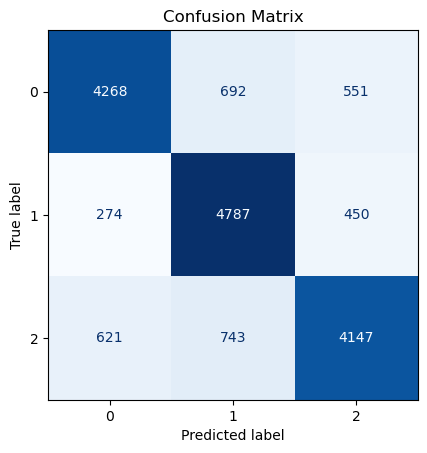

Precision: 0.799, Recall: 0.799, F1: 0.799
Epoch 1: Loss=0.4315, Test Acc=0.799


Evaluating: 100%|██████████| 5511/5511 [01:47<00:00, 51.15it/s]


0 2
0 2
Accuracy: 0.794


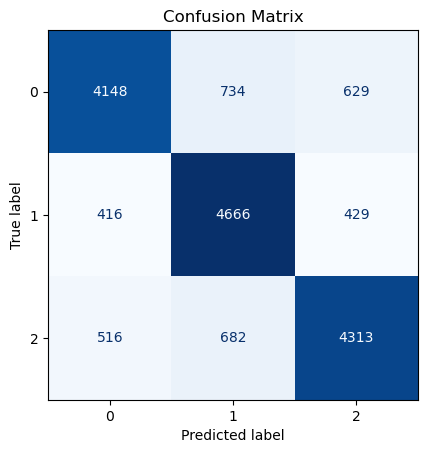

Precision: 0.794, Recall: 0.794, F1: 0.794
Epoch 2: Loss=0.1741, Test Acc=0.794


Evaluating: 100%|██████████| 5511/5511 [03:49<00:00, 23.96it/s]  

0 2
0 2
Accuracy: 0.828


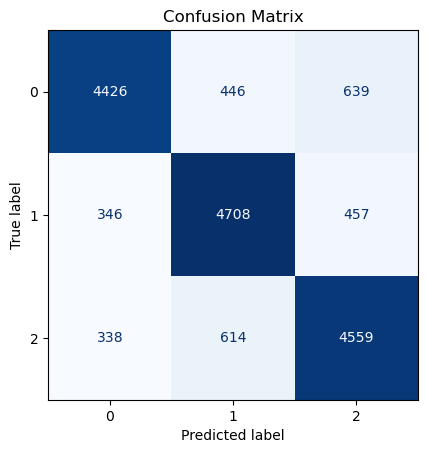

Precision: 0.828, Recall: 0.828, F1: 0.828
Epoch 3: Loss=0.1122, Test Acc=0.828


Evaluating: 100%|██████████| 5511/5511 [01:49<00:00, 50.55it/s]

0 2
0 2
Accuracy: 0.845


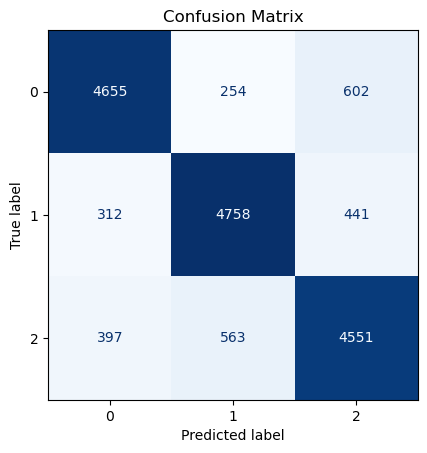

Precision: 0.845, Recall: 0.845, F1: 0.845
Epoch 4: Loss=0.0856, Test Acc=0.845


Evaluating: 100%|██████████| 5511/5511 [01:57<00:00, 46.97it/s]

0 2
0 2
Accuracy: 0.854


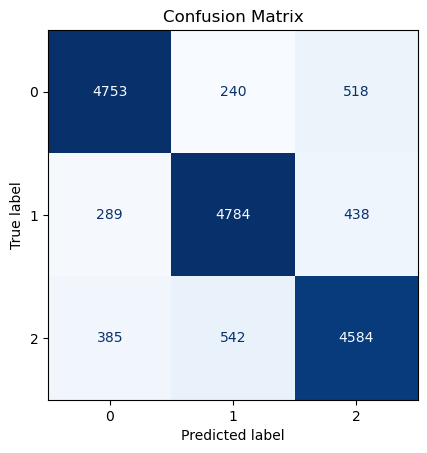

Precision: 0.854, Recall: 0.854, F1: 0.854
Epoch 5: Loss=0.0679, Test Acc=0.854


Evaluating: 100%|██████████| 5511/5511 [01:48<00:00, 51.00it/s]


0 2
0 2
Accuracy: 0.861


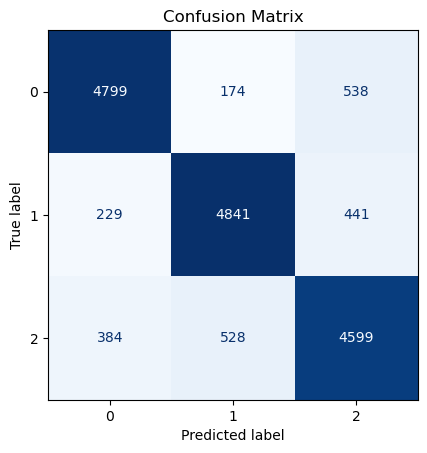

Precision: 0.861, Recall: 0.861, F1: 0.861
Epoch 6: Loss=0.0589, Test Acc=0.861


Evaluating: 100%|██████████| 5511/5511 [02:54<00:00, 31.59it/s] 


0 2
0 2
Accuracy: 0.857


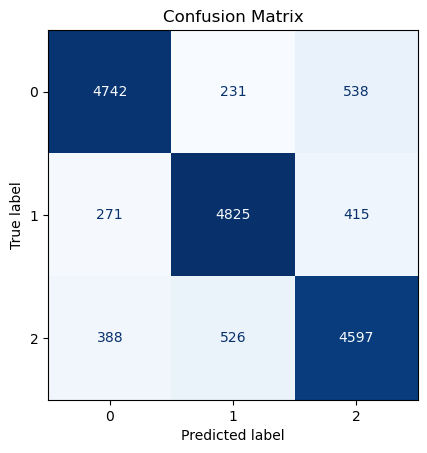

Precision: 0.857, Recall: 0.857, F1: 0.857
Epoch 7: Loss=0.0497, Test Acc=0.857


Evaluating: 100%|██████████| 5511/5511 [04:01<00:00, 22.82it/s]  

0 2
0 2
Accuracy: 0.868


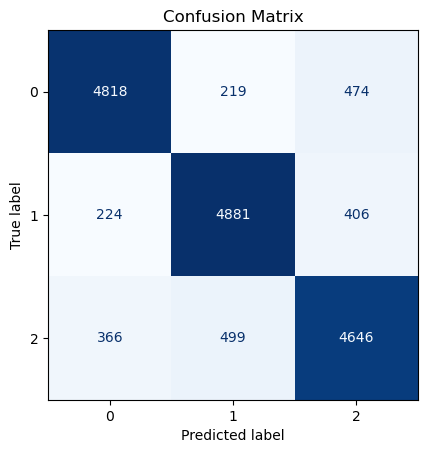

Precision: 0.868, Recall: 0.868, F1: 0.868
Epoch 8: Loss=0.0407, Test Acc=0.868


Evaluating: 100%|██████████| 5511/5511 [01:47<00:00, 51.13it/s]


0 2
0 2
Accuracy: 0.878


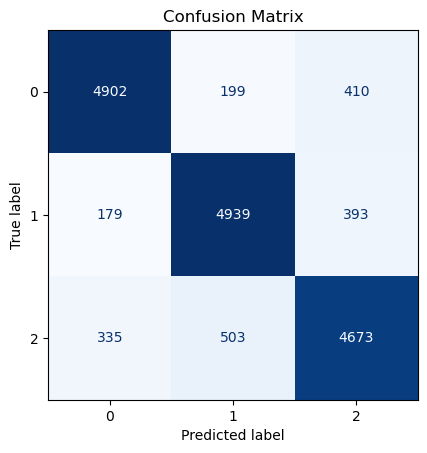

Precision: 0.878, Recall: 0.878, F1: 0.878
Epoch 9: Loss=0.0336, Test Acc=0.878


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.92it/s]


0 2
0 2
Accuracy: 0.888


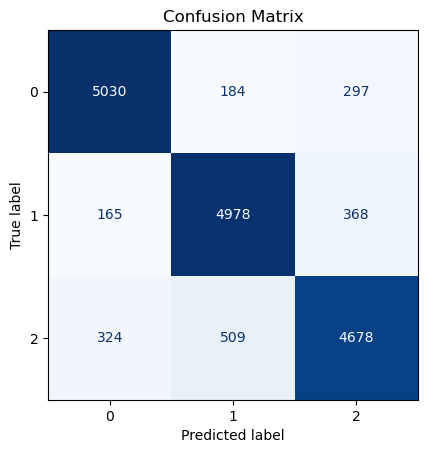

Precision: 0.888, Recall: 0.888, F1: 0.888
Epoch 10: Loss=0.0292, Test Acc=0.888


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.87it/s]


0 2
0 2
Accuracy: 0.895


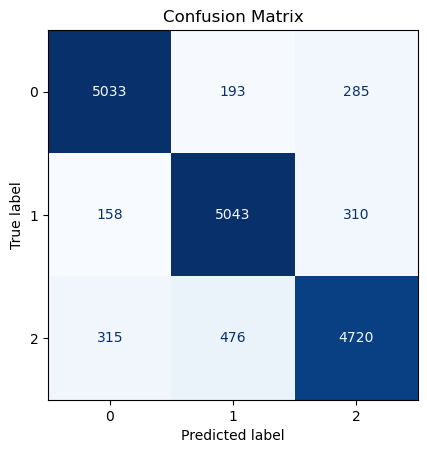

Precision: 0.895, Recall: 0.895, F1: 0.895
Epoch 11: Loss=0.0257, Test Acc=0.895


Evaluating: 100%|██████████| 5511/5511 [01:43<00:00, 53.02it/s]


0 2
0 2
Accuracy: 0.893


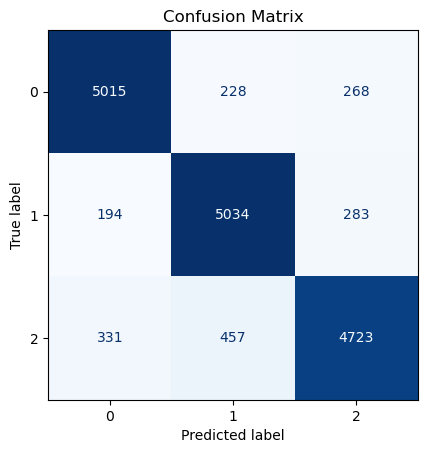

Precision: 0.893, Recall: 0.893, F1: 0.893
Epoch 12: Loss=0.0230, Test Acc=0.893


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.83it/s]


0 2
0 2
Accuracy: 0.892


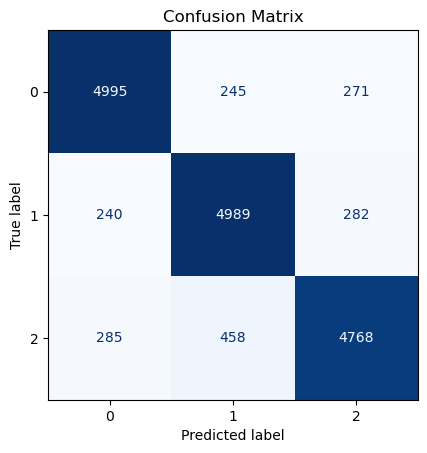

Precision: 0.892, Recall: 0.892, F1: 0.892
Epoch 13: Loss=0.0203, Test Acc=0.892


Evaluating: 100%|██████████| 5511/5511 [01:43<00:00, 53.01it/s]


0 2
0 2
Accuracy: 0.897


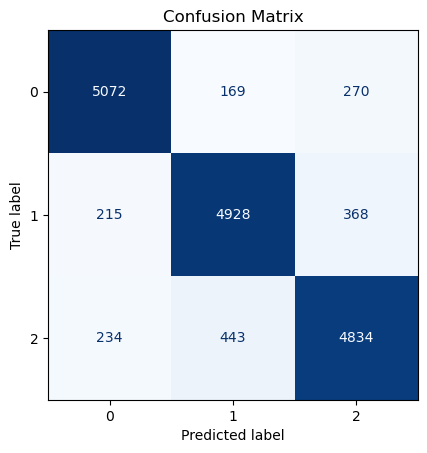

Precision: 0.897, Recall: 0.897, F1: 0.897
Epoch 14: Loss=0.0177, Test Acc=0.897


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.80it/s]


0 2
0 2
Accuracy: 0.894


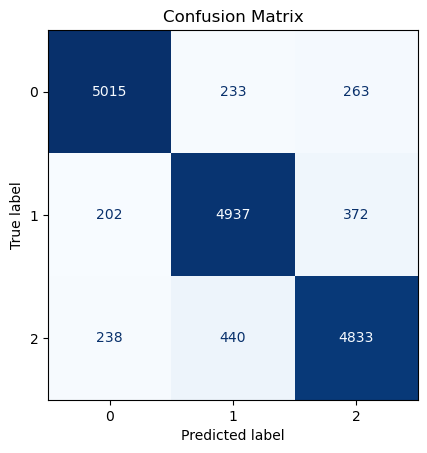

Precision: 0.894, Recall: 0.894, F1: 0.894
Epoch 15: Loss=0.0155, Test Acc=0.894


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.93it/s]


0 2
0 2
Accuracy: 0.891


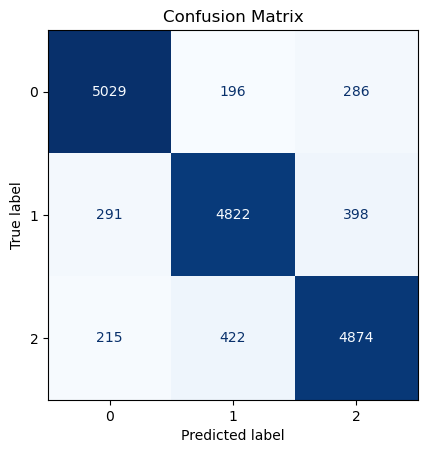

Precision: 0.891, Recall: 0.891, F1: 0.891
Epoch 16: Loss=0.0142, Test Acc=0.891


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.84it/s]


0 2
0 2
Accuracy: 0.892


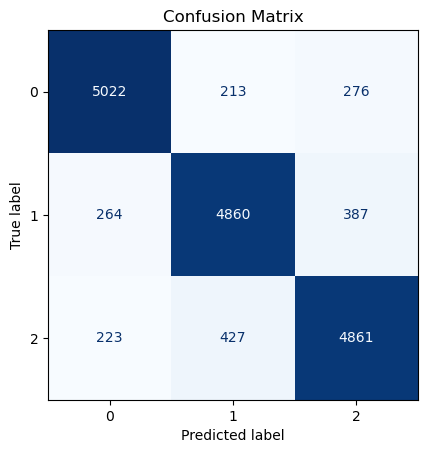

Precision: 0.892, Recall: 0.892, F1: 0.892
Epoch 17: Loss=0.0127, Test Acc=0.892


Evaluating: 100%|██████████| 5511/5511 [01:45<00:00, 52.48it/s]

0 2
0 2
Accuracy: 0.894


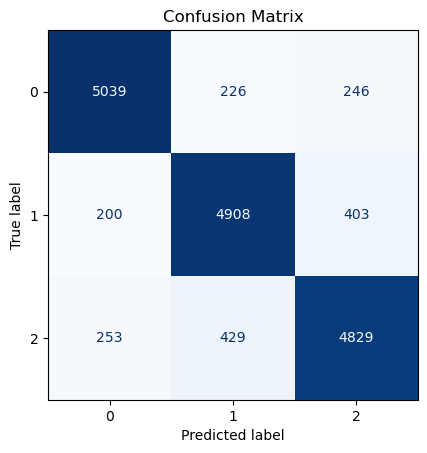

Precision: 0.894, Recall: 0.894, F1: 0.894
Epoch 18: Loss=0.0113, Test Acc=0.894


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.88it/s]


0 2
0 2
Accuracy: 0.893


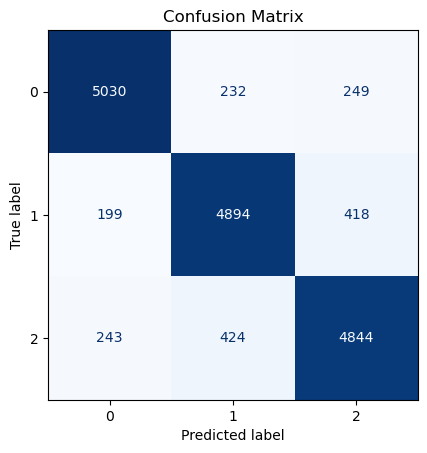

Precision: 0.893, Recall: 0.893, F1: 0.893
Epoch 19: Loss=0.0104, Test Acc=0.893


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.70it/s]


0 2
0 2
Accuracy: 0.893


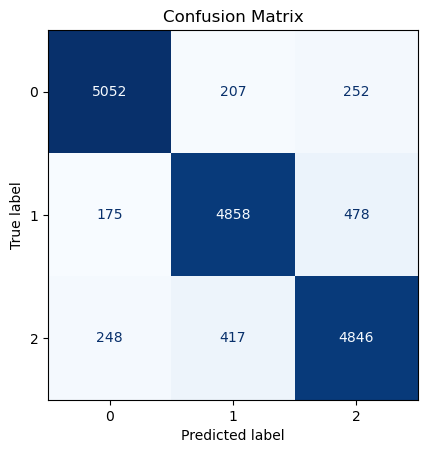

Precision: 0.893, Recall: 0.893, F1: 0.893
Epoch 20: Loss=0.0093, Test Acc=0.893


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.88it/s]


0 2
0 2
Accuracy: 0.896


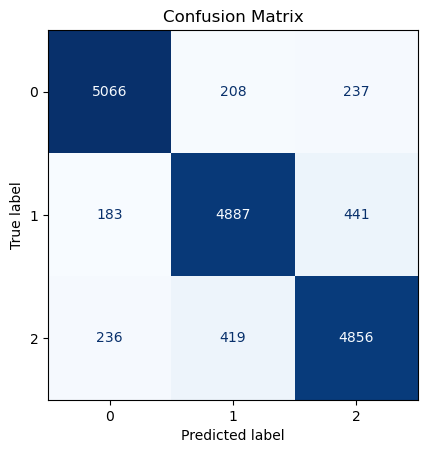

Precision: 0.896, Recall: 0.896, F1: 0.896
Epoch 21: Loss=0.0090, Test Acc=0.896


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.86it/s]


0 2
0 2
Accuracy: 0.894


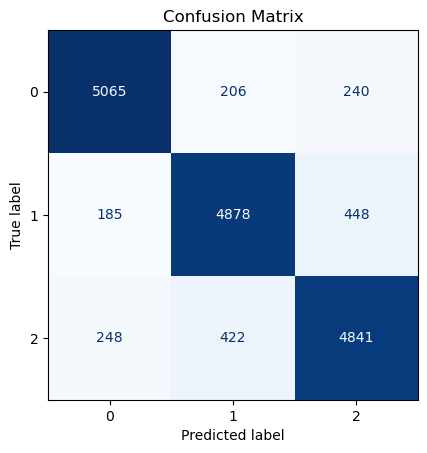

Precision: 0.894, Recall: 0.894, F1: 0.894
Epoch 22: Loss=0.0081, Test Acc=0.894


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.94it/s]


0 2
0 2
Accuracy: 0.894


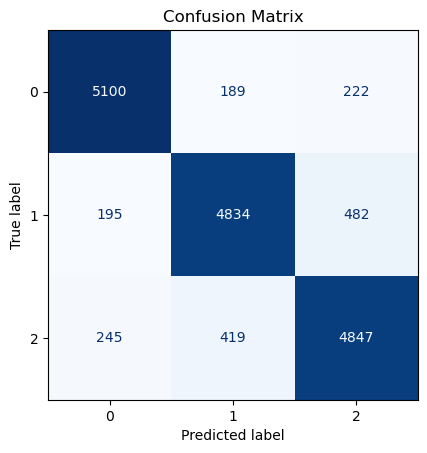

Precision: 0.894, Recall: 0.894, F1: 0.894
Epoch 23: Loss=0.0072, Test Acc=0.894


Evaluating: 100%|██████████| 5511/5511 [01:44<00:00, 52.87it/s]


0 2
0 2
Accuracy: 0.895


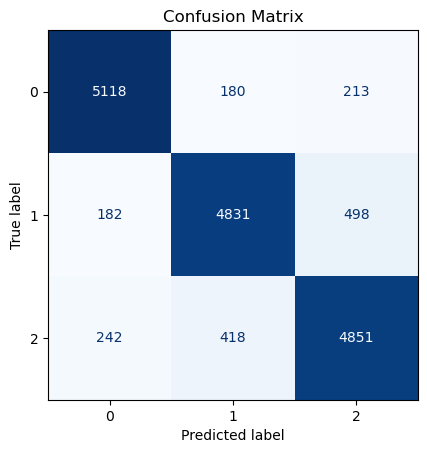

Precision: 0.895, Recall: 0.895, F1: 0.895
Epoch 24: Loss=0.0065, Test Acc=0.895


Evaluating: 100%|██████████| 5511/5511 [01:45<00:00, 52.36it/s]

0 2
0 2
Accuracy: 0.896


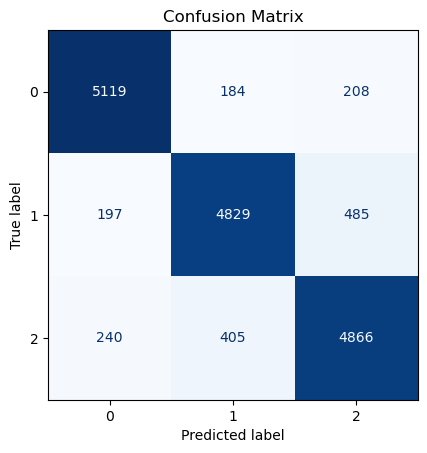

Precision: 0.896, Recall: 0.896, F1: 0.896
Epoch 25: Loss=0.0057, Test Acc=0.896


Evaluating: 100%|██████████| 5511/5511 [01:46<00:00, 51.81it/s]

0 2
0 2
Accuracy: 0.895


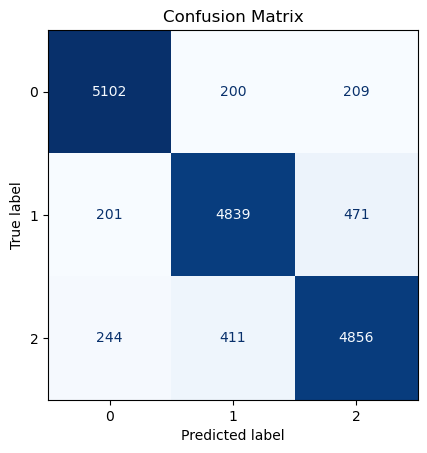

Precision: 0.895, Recall: 0.895, F1: 0.895
Epoch 26: Loss=0.0054, Test Acc=0.895


Evaluating: 100%|██████████| 5511/5511 [02:11<00:00, 41.83it/s]

0 2
0 2
Accuracy: 0.897


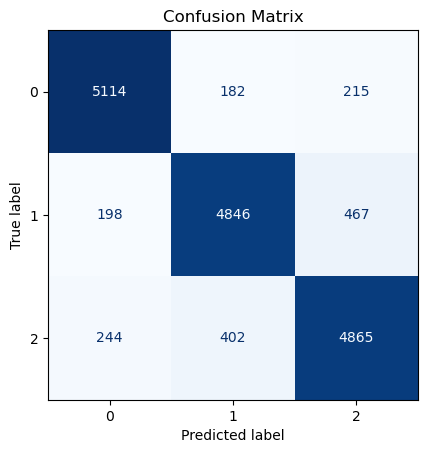

Precision: 0.897, Recall: 0.897, F1: 0.897
Epoch 27: Loss=0.0050, Test Acc=0.897


Evaluating: 100%|██████████| 5511/5511 [02:12<00:00, 41.74it/s]

0 2
0 2
Accuracy: 0.895


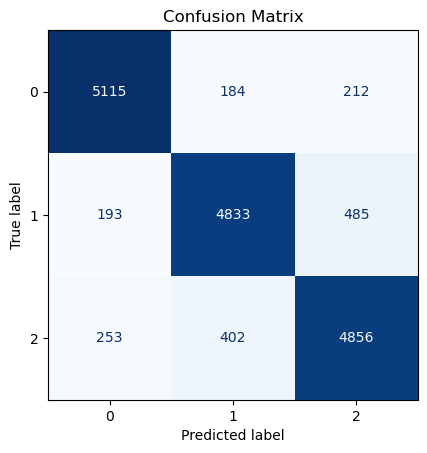

Precision: 0.895, Recall: 0.895, F1: 0.895
Epoch 28: Loss=0.0047, Test Acc=0.895


Evaluating: 100%|██████████| 5511/5511 [02:10<00:00, 42.35it/s]


0 2
0 2
Accuracy: 0.895


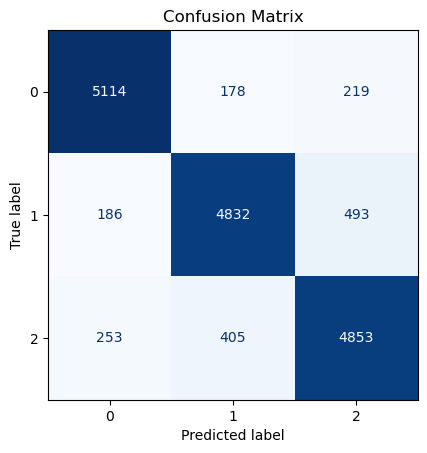

Precision: 0.895, Recall: 0.895, F1: 0.895
Epoch 29: Loss=0.0044, Test Acc=0.895


Evaluating: 100%|██████████| 5511/5511 [02:12<00:00, 41.68it/s]


0 2
0 2
Accuracy: 0.893


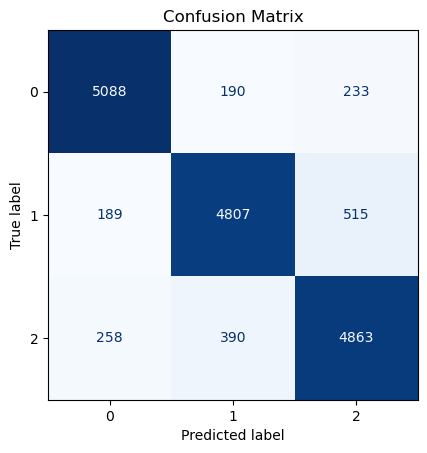

Precision: 0.893, Recall: 0.893, F1: 0.893
Epoch 30: Loss=0.0041, Test Acc=0.893


In [11]:
# Load pretrained trajectory model
model_traj, config = load_pretrained_traj_model(experiment_dir, device)
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Initialize new relation model
relation_model = DroneRelationModel(context_dim=model_traj.dec_hidden_size).to(device)
# relation_model = DroneRelationModel(
#     context_dim=model_traj.enc_hidden_size * 2,
# ).to(device)

# optimizer = optim.Adam(relation_model.parameters(), lr=1e-3)
optimizer = optim.Adam(
    [
        {"params": relation_model.parameters(), "lr": 1e-4},
        {"params": model_traj.parameters(), "lr": 1e-4},
    ]
)
# pos_weight = torch.tensor([2.0], device=device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()

# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(30):
    loss = train_epoch(
        relation_model, train_ds, optimizer, criterion, scaler_X, model_traj, config
    )
    acc = evaluate(relation_model, test_ds, scaler_X, model_traj, config)
    print(f"Epoch {epoch + 1}: Loss={loss:.4f}, Test Acc={acc:.3f}")


# # Load pretrained trajectory model
# model_traj, config = load_pretrained_traj_model(experiment_dir, device)
# scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# # Initialize VGAE model (instead of DroneRelationModel)
# vgae_model = VGAE(
#     in_dim=model_traj.dec_hidden_size,  # same as your current context_dim
#     hidden_dim=128,
#     latent_dim=64,
#     decoder_type="dot",  # or "bilinear" for directed
#     device=device
# ).to(device)

# optimizer = torch.optim.Adam([
#     {"params": vgae_model.parameters(), "lr": 1e-4},
#     {"params": model_traj.parameters(), "lr": 1e-4},
# ])

# # Training loop
# for epoch in range(10):
#     loss = train_epoch_vgae(vgae_model, train_ds, optimizer, scaler_X, model_traj, config, device)
#     acc = evaluate_vgae(vgae_model, test_ds, scaler_X, model_traj, config, device)
#     print(f"Epoch {epoch+1}: Loss={loss:.4f}, Test Acc={acc:.3f}")